# Aprendizaje Automatico - TP 1

In [1]:
%matplotlib inline

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

In [3]:
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [4]:
import email_text_retrieval as tr

#### Funciones Auxiliares

In [5]:
def load_data():
    ham_txt = json.load(open('dataset/ham_dev.json'))
    spam_txt = json.load(open('dataset/spam_dev.json'))
    df = pd.DataFrame(ham_txt + spam_txt, columns=['text'])
    df['label'] = ['ham' for _ in range(len(ham_txt))] + ['spam' for _ in range(len(spam_txt))]
    return train_test_split(df, test_size=0.20)

In [6]:
def cross_validate(clf, X_train, y_train, cv_folds=5, n_jobs=4):
    clf_descr = str(clf).split('(')[0]
    print "Running %d-Fold Cross Validation for %s" % (cv_folds, clf_descr)
    
    t0 = time()
    cv_scores = cross_val_score(clf, X_train, y_train, cv=cv_folds, n_jobs=n_jobs)
    cv_time = time() - t0
    
    print "Done in %fs" % cv_time
    print "CV Score: mean %f std %f" % (np.mean(cv_scores), np.std(cv_scores))

In [7]:
def benchmark(clf, X_train, y_train, X_test, y_test, print_report=True, print_cm=True):
    print "-" * 80
    clf_descr = str(clf).split('(')[0]
    print "Benchmark for ", clf_descr
    print "-" * 80
    
    print "Training "
    
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    
    print "Done in %fs" % train_time
    
    print "Running Test Score"
    
    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    
    test_score = metrics.accuracy_score(y_test, pred)
    print "Done in %fs" % test_time    
    print "Test Score:   %f" % test_score
    
    classes = np.unique(y_test)

    if print_report:
        print "Classification report:"
        print metrics.classification_report(y_test, pred, labels=classes)

    if print_cm:
        plt.matshow(metrics.confusion_matrix(y_test, pred), cmap=plt.cm.binary, interpolation='nearest')
        plt.title('Confusion matrix',)
        plt.colorbar()
        plt.ylabel('Expected label')
        plt.xlabel('Predicted label')

## Features

Aca definimos distintos tipos de features para hacer las pruebas

In [8]:
def simple_features(data_train, data_test):
    # Extraigo dos atributos simples: 
    # 1) Longitud del mail.
    # 2) Cantidad de espacios en el mail.
    
    extractors = [ ('len', len), ('count_spaces', lambda txt : txt.count(" ")) ]
    
    df_train = pd.DataFrame({ e[0]: data_train.text.apply(e[1]).values for e in extractors })
    df_test = pd.DataFrame({ e[0]: data_test.text.apply(e[1]).values for e in extractors })
       
    X_train = df_train[[e[0] for e in extractors]].values
    X_test = df_test[[e[0] for e in extractors]].values
        
    print "Training Set: %d samples %d features" % X_train.shape
    print "Test     Set: %d samples %d features" % X_test.shape

    return X_train, X_test

In [9]:
def sklearn_doc_classification_features(data_train, data_test, use_hashing=True):
    print "Extracting features from the training data using a sparse vectorizer"

    t0 = time()
    if use_hashing:
        n_features = 2 ** 18
        vectorizer = HashingVectorizer(stop_words='english', non_negative=True, n_features=n_features)
        X_train = vectorizer.transform(data_train.text)
    else:
        vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
        X_train = vectorizer.fit_transform(data_train.text)
    duration = time() - t0

    print "Done in %fs" % duration
    
    print "Extracting features from the test data using the same vectorizer"

    t0 = time()
    X_test = vectorizer.transform(data_test.text)
    duration = time() - t0

    print "Done in %fs" % duration
    print ""
    
    print "Training Set: %d samples %d features" % X_train.shape
    print "Test     Set: %d samples %d features" % X_test.shape
    
    return X_train, X_test

In [10]:
def our_features(data_train, data_test, tf_idf=False):
    print "Extracting features from the training data using a BoW sparse vectorizer"    
    bag_of_words_vectorizer = CountVectorizer(tokenizer=tr.LemmaTokenizer())
    t0 = time()
    bow_train = bag_of_words_vectorizer.fit_transform(data_train.text)
    duration = time() - t0    
    print "Done in %fs" % duration
    
    if tf_idf:
        print "Applying term weighting on the training features using TF-IDF"
        tfidf_transformer = TfidfTransformer(sublinear_tf=True, min_df=0.01, max_df=0.7)
        t0 = time()
        X_train = vectorizer.fit_transform(bow_train)
        duration = time() - t0
        print "Done in %fs" % duration
    else:
        X_train = bow_train
    
    print "Extracting features from the test data using the same vectorizer"
    t0 = time()
    bow_test = bag_of_words_vectorizer.transform(data_test.text)
    duration = time() - t0
    print "Done in %fs" % duration
    
    if tf_idf:
        print "Applying term weighting on the test features using TF-IDF"
        t0 = time()
        X_test = tfidf_transformer.transform(bow_test)        
        duration = time() - t0
        print "Done in %fs" % duration
    else:
        X_test = bow_test
    
    print ""
    
    print "Training Set: %d samples %d features" % X_train.shape
    print "Test     Set: %d samples %d features" % X_test.shape
    
    return X_train, X_test

## Experimentacion

Cargamos y spliteamos el dataset

In [11]:
data_train, data_test = load_data()
print "Training Set: %d samples (%0.3fMB)" % (len(data_train), sum(len(m.encode('utf-8')) for m in data_train.text) / 1e6)
print "Test Set:     %d samples (%0.3fMB)" % (len(data_test), sum(len(m.encode('utf-8')) for m in data_test.text) / 1e6)

Training Set: 72000 samples (545.195MB)
Test Set:     18000 samples (120.594MB)


##### Features del Baseline Example

In [12]:
X_train, X_test = simple_features(data_train, data_test)

Training Set: 72000 samples 2 features
Test     Set: 18000 samples 2 features


--------------------------------------------------------------------------------
Benchmark for  DecisionTreeClassifier
--------------------------------------------------------------------------------
Training 
Done in 0.326000s
Running Test Score
Done in 0.007000s
Test Score:   0.695889
Classification report:
             precision    recall  f1-score   support

        ham       0.69      0.70      0.70      9030
       spam       0.70      0.69      0.69      8970

avg / total       0.70      0.70      0.70     18000



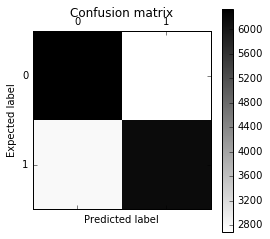

In [13]:
benchmark(DecisionTreeClassifier(), X_train, data_train.label, X_test, data_test.label)

##### Features nuestros

In [ ]:
X_train, X_test = our_features(data_train, data_test)

Extracting features from the training data using a BoW sparse vectorizer


In [ ]:
benchmark(DecisionTreeClassifier(), X_train, data_train.label, X_test, data_test.label)